In [221]:
%cd "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval"

import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset_microf1, create_loaders_microf1
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer

cfg = load_config('config/base_local.yaml')

cuda_available = True
    
set_seed(cfg["training"]["seed"])
configure_environment(cfg)

print("=== MICRO-F1 TRAINING MODE ===")

# Detect Jupyter environment if not specified

# Setup directories
run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])
checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

# Load dataset with device parameter
train_set, train_eval_set, test_set, neg_compatibles = load_dataset_microf1(
    #cfg["paths"]["dr2156"]["preprocessed_300_int8"],
    cfg["paths"]["dr2156"]["preprocessed_270_uint8"],
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    float(cfg["dataset"]["train_eval_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

# Initialize model
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)


loaders = create_loaders_microf1(
    train_set,
    train_eval_set,
    test_set, 
    cfg["training"]["batch"]["batch_size"],
    cuda_available
)

# Load metrics
p_metrics = load_metrics(cfg)

[Errno 2] No such file or directory: 'E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval'
/net/backups/exports/dataChivo/jpmunoz/chest_ct_retrieval
=== MICRO-F1 TRAINING MODE ===


In [223]:
import os
import torch
from models.networks import Proximity100x100

#BEST_MODEL_PATH = os.path.join('E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_microf1\\run_20250805_0721_euclidean\checkpoints\microf1_20250805_epoch=051_mAP@10=0.6263.pth')

# E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\runs_bce-microf1\run_20250809_0313\checkpoints\microf1_20250809_epoch=060_mAP@10=0.5999.pth

BEST_MODEL_PATH = os.path.join('/dataChivo/jpmunoz/chest_ct_retrieval/runs_bce-microf1/run_20250809_1803/checkpoints/triplets_20250812_epoch=079_mAP@10=0.5844_avg-nonzero-val-triplets=0.8.pth')


best_model = Proximity100x100(embedding_size=1024, num_classes=4, task="classification").cuda()
model_state = torch.load(BEST_MODEL_PATH)
best_model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [224]:
from torch.utils.data import DataLoader
import kornia.augmentation as K
from utils.transforms import RandomGaussianNoise3D
import numpy as np

ct_depth = 300
ct_resize_H = 270
ct_resize_W = 270

gpu_aug = K.AugmentationSequential(
    K.RandomAffine3D(degrees=(5, 5, 5), scale=(0.95, 1.05), p=0.5),
    RandomGaussianNoise3D(mean=0.0, std=0.01, p=0.5),
    data_keys=["input"]
).to("cuda")

def collate_tensor_batch(batch, apply_gpu_aug=False):
    samples = []
    transposed_target = []

    for sample, target in batch:
        samples.append(sample)
        transposed_target.append(target)

    samples = torch.tensor(np.array(samples))  # [B, D, 1, H, W]
    transposed_target = torch.tensor(transposed_target)

    samples = samples.permute(0, 2, 1, 3, 4)  # → [B, 1, D, H, W]
    # samples = F.interpolate(
    #     samples,
    #     size=[ct_depth, ct_resize_H, ct_resize_W],
    #     mode='trilinear',
    #     align_corners=False
    # )

    # Don't use GPU transforms here if num_workers > 0
    if apply_gpu_aug:
        raise RuntimeError("Cannot apply GPU transforms in collate_fn with num_workers > 0")

    samples = samples.permute(0, 2, 1, 3, 4)  # → [B, D, 1, H, W]
    samples /= 255.0
    samples = (samples - 0.449) / 0.226

    return samples, transposed_target

class CollateFn:
    def __init__(self, apply_gpu_aug=False):
        self.apply_gpu_aug = apply_gpu_aug

    def __call__(self, batch):
        return collate_tensor_batch(batch, apply_gpu_aug=self.apply_gpu_aug)


In [225]:

kwargs = {'num_workers': 0, 'prefetch_factor': None, 'persistent_workers': None, 'pin_memory': True}

train_dataloader = DataLoader(train_set, collate_fn=CollateFn(apply_gpu_aug=False), batch_size=24, **kwargs)
test_dataloader = DataLoader(test_set, collate_fn=CollateFn(apply_gpu_aug=False), batch_size=24, **kwargs)

torch.Size([300, 270, 270])
tensor([[[1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         ...,
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924]],

        [[1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         ...,
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924]],

        [[1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.6924,  ..., 1.6924, 1.6924, 1.6924],
         [1.6924, 1.6924, 1.69

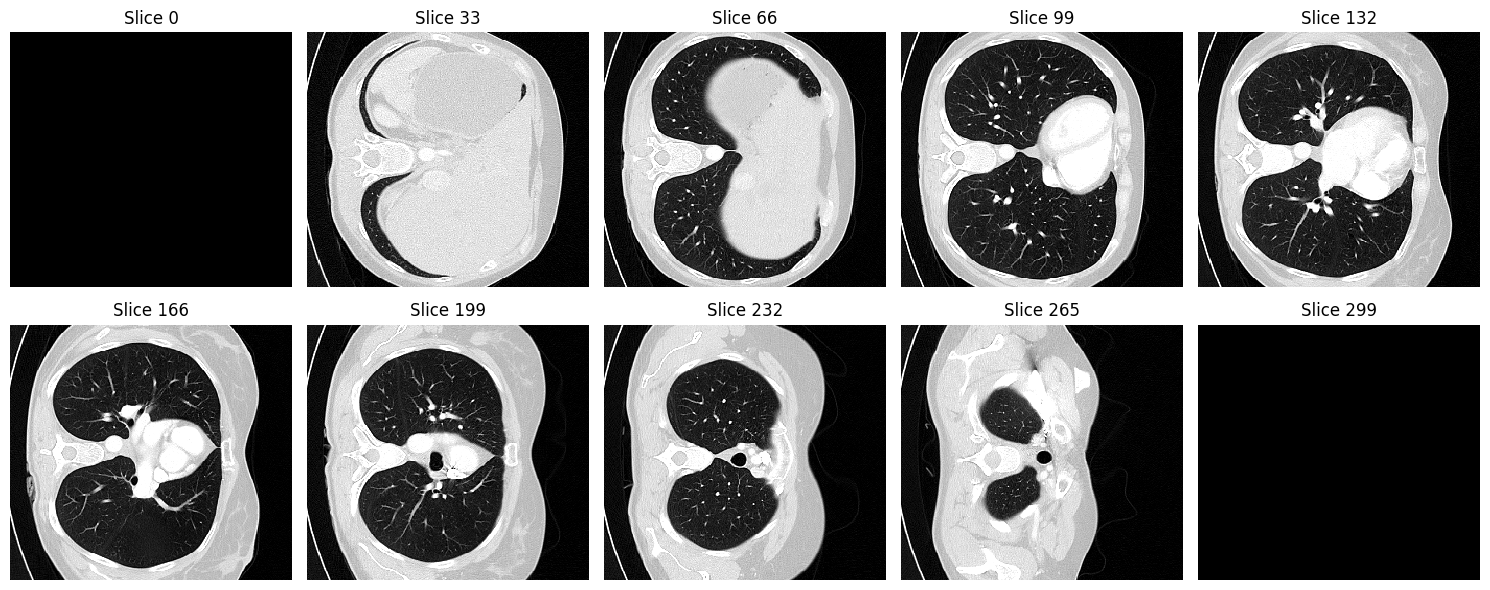

In [226]:
import matplotlib.pyplot as plt

data = None

for batch, target in train_dataloader:
    data = batch[0]
    break

data = data.permute(1, 0, 2, 3) # [1, D, H, W]

s_vol = data[0]
depth = s_vol.shape[0]

print(s_vol.shape)
print(s_vol)

# Select 10 equally spaced indices across the depth axis
n_slices = 10
indices = np.linspace(0, depth - 1, n_slices, dtype=int)

# Plot the selected slices in a grid
cols = 5
rows = (n_slices + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(s_vol[idx].numpy(), cmap='gray', aspect='auto', interpolation='none')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')
    axes[i].set_frame_on(False)  # Remove subplot border

# Hide unused subplots
for ax in axes[n_slices:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [227]:
from torch.amp import autocast
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from datasets.base import LabelVectorHelper

# Assume: model, train_loader already defined
best_model.eval()
all_embeddings = []
all_labels = []

helper = LabelVectorHelper()

with torch.no_grad():
    for batch, target in tqdm(train_dataloader):
        with autocast('cuda', enabled=True):
            x, y = batch.cuda(), target.cpu()  # Ensure labels stay on CPU
            emb = best_model.get_embeddings(x).cpu()
            all_embeddings.append(emb)
            all_labels.append(y)

X_train = torch.cat(all_embeddings).numpy()  # [N, E = 1024]
Y_train = torch.cat(all_labels).numpy()      # [N, C] multilabel binarized vectors

Y_train_binarized = np.array([helper.get_class_id(y_vector.tolist()) for y_vector in Y_train])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [12:15<00:00,  9.55s/it]


In [228]:
X_train

array([[ 0.00544549,  0.04907929,  0.02757692, ..., -0.02778025,
        -0.06379545, -0.02927983],
       [-0.03677108,  0.02125333,  0.04750331, ..., -0.02767508,
         0.01421581,  0.01073223],
       [-0.02458913,  0.04671651,  0.02828174, ..., -0.0226933 ,
        -0.04368885, -0.0130444 ],
       ...,
       [-0.00736221,  0.03017562,  0.02814065, ..., -0.02991398,
        -0.04904264, -0.03729799],
       [-0.01244502,  0.0657682 ,  0.02294826, ..., -0.02922751,
        -0.0574463 , -0.02031299],
       [ 0.01628593,  0.04181383,  0.03279686, ..., -0.02758743,
        -0.06372455, -0.02367604]], shape=(1832, 1024), dtype=float32)

In [231]:
np.savez_compressed('/dataChivo/jpmunoz/chest_ct_retrieval/data/DR2156/DR2156_embeddings/train_set_embeddings_bce-microf1_triplets.npz', train_set_embeddings=X_train, train_set_labels=Y_train_binarized)

In [232]:
from torch.amp import autocast
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from datasets.base import LabelVectorHelper

# Assume: model, train_loader already defined
best_model.eval()
all_embeddings = []
all_labels = []

helper = LabelVectorHelper()

with torch.no_grad():
    for batch, target in tqdm(test_dataloader):
        with autocast('cuda', enabled=True):
            x, y = batch.cuda(), target.cpu()  # Ensure labels stay on CPU
            emb = best_model.get_embeddings(x).cpu()
            all_embeddings.append(emb)
            all_labels.append(y)


X_test = torch.cat(all_embeddings).numpy()  # [N, D]
Y_test = torch.cat(all_labels).numpy()      # [N, C] multilabel binarized vectors

Y_test_binarized = np.array([helper.get_class_id(y_vector.tolist()) for y_vector in Y_test])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [02:11<00:00,  9.42s/it]


In [233]:
X_test

array([[-0.00783197,  0.0197009 ,  0.02318485, ..., -0.03677501,
        -0.04623144, -0.05411179],
       [-0.01287889, -0.01217573,  0.03343084, ..., -0.02945861,
         0.00158827, -0.03700831],
       [-0.03910415,  0.0179762 ,  0.02397577, ..., -0.05078812,
        -0.02124051, -0.01511712],
       ...,
       [-0.00336464,  0.03481821,  0.02651541, ..., -0.02703433,
        -0.0508212 , -0.03552127],
       [-0.01821345,  0.02224559,  0.03469604, ..., -0.02710382,
        -0.04295699, -0.04421581],
       [-0.02737809,  0.03483035,  0.02118116, ..., -0.04634749,
        -0.05459678, -0.03309681]], shape=(324, 1024), dtype=float32)

In [234]:
np.savez_compressed('/dataChivo/jpmunoz/chest_ct_retrieval/data/DR2156/DR2156_embeddings/val_set_embeddings_bce-microf1_triplets.npz', val_set_embeddings=X_test, val_set_labels=Y_test_binarized)

In [289]:
import numpy as np
import matplotlib.pyplot as plt

proximity_classes = [
    '(Otros/Sin Anomalías)', 'Condensación', 'Nódulos', 'Quistes',
    'Cond.+Quis.', 'Cond.+Nóds.', 'Nóds.+Quis.', 'Cond.+Nóds.+Quis.'
]

proximity_colors = [
    '#000000', '#ff0000', '#00ff00', '#0000ff',
    '#ff00ff', '#ffff00', '#00ffff', '#ffffff'
]


def plot_projection_grid(X_proj, Y_binarized, global_title="Proyección de puntos"):
    """
    Generate a 2x2 grid of projected plots:
    - Normal vs Abnormal
    - Condensación
    - Nódulos
    - Quistes

    Parameters
    ----------
    X_proj : np.ndarray
        2D array of projected points (n_samples, 2)
    Y_binarized : np.ndarray
        Binarized labels for each sample (0..7)
    global_title : str
        Title shown at the top of the figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()

    # 1) Normal vs Abnormal
    ax = axes[0]
    normal_mask = (Y_binarized == 0)
    abnormal_mask = ~normal_mask

    ax.scatter(
        X_proj[abnormal_mask, 0], X_proj[abnormal_mask, 1],
        facecolors='dimgray', edgecolors='dimgray', s=15, label='Con anomalías'
    )
    ax.scatter(
        X_proj[normal_mask, 0], X_proj[normal_mask, 1],
        facecolors='white', edgecolors='black', s=15, label='Otros/Sin anomalías'
    )
    ax.set_title('Otros/Sin anomalías vs Anomalía detectada')
    ax.legend(loc="lower right")

    # Helper for per-class plots
    def plot_class_subset(ax, class_labels, title):
        # Background points once
        mask = np.isin(Y_binarized, class_labels)
        ax.scatter(
            X_proj[~mask, 0], X_proj[~mask, 1],
            facecolors='lightgray', edgecolors='lightgray', s=15, label='Otras clases'
        )
        # Colored subsets
        for lbl in class_labels:
            idx = (Y_binarized == lbl)
            if lbl == 7:
                ax.scatter(
                    X_proj[idx, 0], X_proj[idx, 1],
                    facecolors=proximity_colors[lbl], edgecolors='dimgray',
                    s=15, label=proximity_classes[lbl]
                )
            else:
                ax.scatter(
                    X_proj[idx, 0], X_proj[idx, 1],
                    color=proximity_colors[lbl], s=15, label=proximity_classes[lbl]
                )
        ax.set_title(title)
        ax.legend(loc="lower right")

    # 2) Condensación
    plot_class_subset(axes[1], [1, 4, 5, 7], "Condensación")

    # 3) Nódulos
    plot_class_subset(axes[2], [2, 5, 6, 7], "Nódulos")

    # 4) Quistes
    plot_class_subset(axes[3], [3, 4, 6, 7], "Quistes")

    # Remove tick labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Global title
    fig.suptitle(global_title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
    plt.show()


In [300]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_test)

tsne_train = TSNE(n_components=2, random_state=0, perplexity=128)
tsne_test = TSNE(n_components=2, random_state=0, perplexity=16)
X_train_tsne = tsne_train.fit_transform(X_train)
X_val_tsne = tsne_test.fit_transform(X_test)

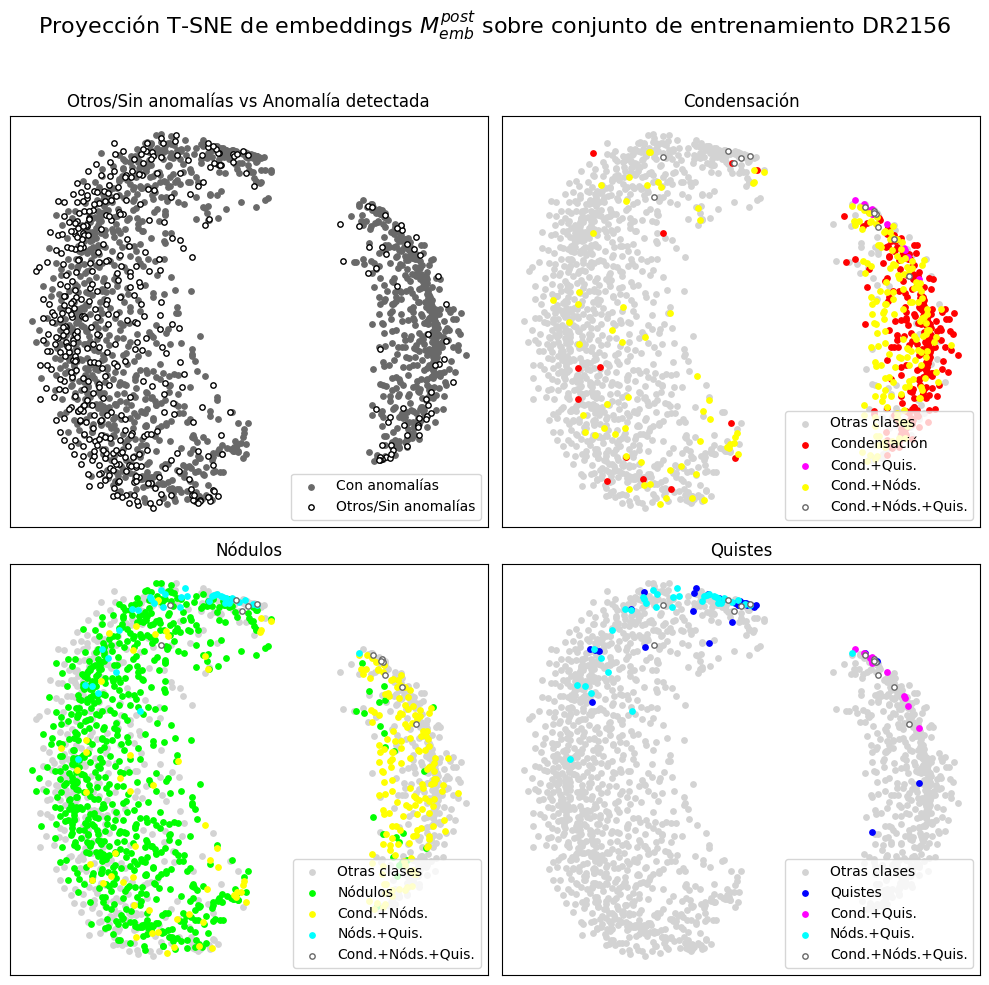

In [ ]:
plot_projection_grid(X_train_tsne, Y_train_binarized, global_title='Proyección T-SNE de embeddings ' + r"$M_{emb}^{post}$" + ' sobre conjunto de entrenamiento DR2156')

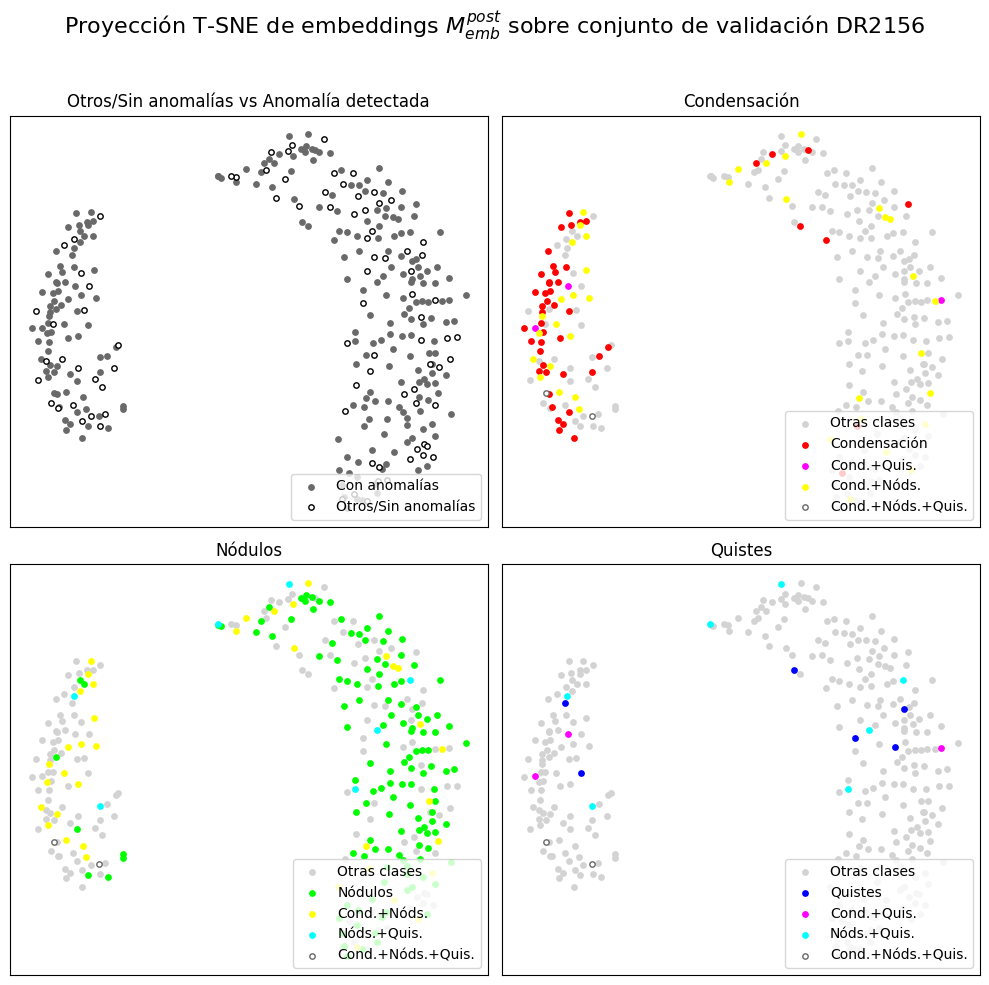

In [303]:
plot_projection_grid(X_val_tsne, Y_test_binarized, global_title='Proyección T-SNE de embeddings ' + r"$M_{emb}^{post}$" + ' sobre conjunto de validación DR2156')

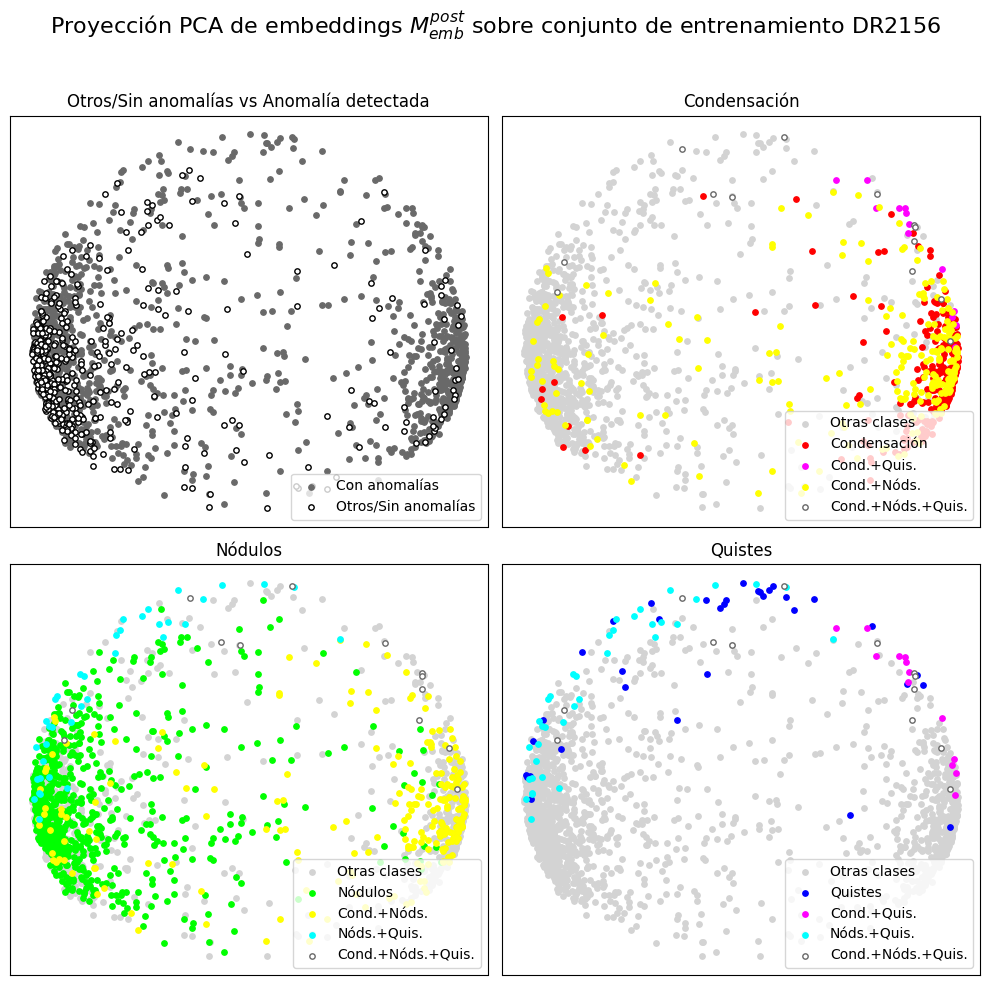

In [299]:
plot_projection_grid(X_train_pca, Y_train_binarized, global_title='Proyección PCA de embeddings ' + r"$M_{emb}^{post}$" + ' sobre conjunto de entrenamiento DR2156')